# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, RocCurveDisplay

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [ ]:
#dataset = pd.read_csv("./data/loan_data.csv", comment="#")
dataset = pd.read_csv("https://raw.githubusercontent.com/DiploDatos/IntroduccionAprendizajeAutomatico/master/data/loan_data.csv", comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Se puede obtener información del dataset

In [ ]:
dataset.head()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106


In [ ]:
dataset.describe()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,0.166667,19111.758360,76316.051780,107321.088457,8.900216,0.187702,0.319849,180.300783,1.128910,21.857066,34.573408
std,0.372779,11000.345961,46227.026585,56039.685066,7.552677,0.704882,0.928452,84.838308,1.664555,9.510840,9.308794
min,0.000000,1700.000000,5627.000000,21144.000000,0.000000,0.000000,0.000000,0.486711,0.000000,0.000000,0.838118
25%,0.000000,12000.000000,48984.750000,70787.250000,3.000000,0.000000,0.000000,116.970718,0.000000,16.000000,29.427210
50%,0.000000,17000.000000,67201.000000,94198.000000,7.000000,0.000000,0.000000,174.967815,1.000000,21.000000,35.363407
75%,0.000000,23900.000000,93731.500000,122976.250000,13.000000,0.000000,0.000000,232.261800,2.000000,27.000000,39.357987
max,1.000000,89800.000000,399412.000000,512650.000000,41.000000,10.000000,10.000000,1168.233561,13.000000,65.000000,144.189001


Se puede observar que la variable objetivo esta desbalanceada

In [ ]:
dataset.TARGET.value_counts()

TARGET
0    1545
1     309
Name: count, dtype: int64

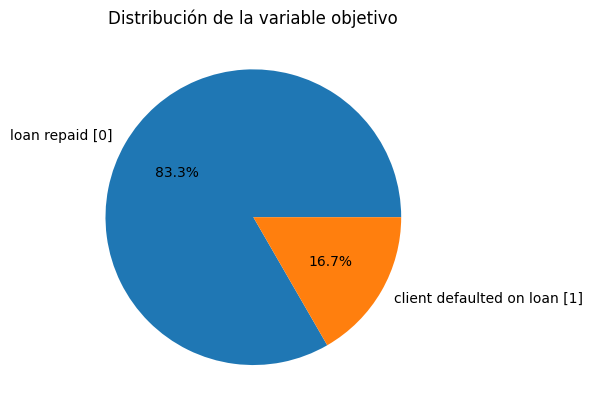

In [ ]:
plt.pie(dataset.TARGET.value_counts(), labels=['loan repaid [0]', 'client defaulted on loan [1]'], autopct='%1.1f%%')
plt.title('Distribución de la variable objetivo')
plt.show()


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

### Respuestas
1. Es un conjunto de datos del departamento de creditos de un banco con la finalidad de automatizar el proceso de aprobacion de créditos con garantía hipotecaria.

2. La variable objetivo indica si el cliente pago o no el prestamo.
    - 1 = el cliente no cumplio con el pago del prestamo
    - 0 = prestamo pagado.

3. Los atributos son:
    - Loan: monto del prestamo
    - Mortdue: monto a pagar de la hipoteca existente
    - Value: valor de la propiedad actual
    - Yoj: años en el trabajo actual
    - Derog: número de informes derogatorios importantes
    - Deliq: número de lineas de crédito morosas
    - Clage: años de la línea comercial más antigua en meses
    - Ninq: número de líneas de crédito recientes
    - Clno: número de líneas de crédito
    - Debtinc: relación deuda-ingresos

4. Los atributos más determinantes para la predicción serán: Mortdue, Value, Debtinc

Se puede ver la correlación entre las distintas variables

Text(0.5, 1.0, 'Matriz de correlación')

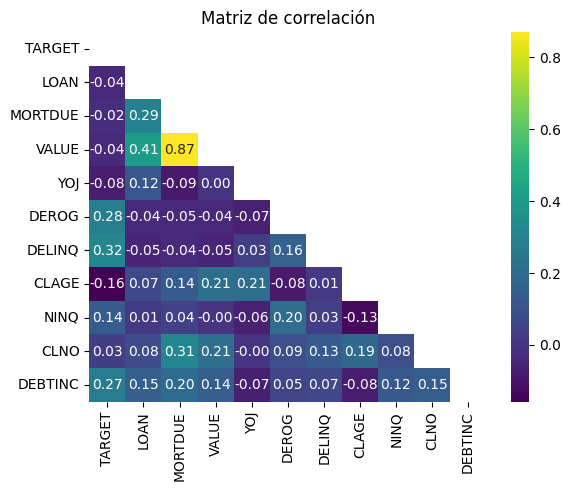

In [ ]:
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(data=corr, mask=mask, annot=True, fmt='.2f', cmap='viridis')
plt.title('Matriz de correlación')

Según la correlación, las variables más determinantes serán: DELINQ, DEROG y DEBTINC

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

### Respuestas

Definimos dos funciones para poder observar las métricas de los distintos modelos

In [ ]:
def metrics_display(model, X_test, y_test):
    test_prediction = model.predict(X_test)

    precision = precision_score(y_test, test_prediction)
    recall = recall_score(y_test, test_prediction)
    f1 = f1_score(y_test, test_prediction)
    accuracy = accuracy_score(y_test, test_prediction)

    print('Test results:')
    print(f'Precision:\t{precision:.3f}')
    print(f'Recall:\t\t{recall:.3f}')
    print(f'F1-Score:\t{f1:.3f}')
    print(f'Accuracy:\t{accuracy:.3f}')

    cm_test = confusion_matrix(y_test, test_prediction)
    plot_confusion_matrix(cm_test, 'Test')

    return test_prediction, [precision, recall, f1, accuracy]

def plot_confusion_matrix(cm, title):
    group_names = ['TN', 'FP', 'FN', 'TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]

    labels = np.asarray(labels).reshape(2, 2)

    fig, ax = plt.subplots(figsize=(3, 3))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Reds', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_xticklabels(['0', '1'])
    ax.set_yticklabels(['0', '1'])
    plt.show()

In [ ]:
results = []

Las metricas evaluadas son:
- **Accuracy (Exactitud):** es la proporción de predicciones correctas (tanto verdaderos positivos como verdaderos negativos, TP y TN) entre el total de predicciones realizadas. Es una métrica general que mide el rendimiento global del modelo
- **Precision:** mide la proporción de verdaderos positivos entre todas las predicciones positivas. Indica qué tan bien el modelo identifica solo las instancias relevantes
- **Recall (Sensitividad):** mide la proporción de verdaderos positivos entre todas las instancias que realmente son positivas
- **F1:** es la media armónica entre la precision y recall. Proporciona un equilibrio entre las dos métricas, siendo útil cuando se necesita un balance entre precisión y recuperación.
- **Matriz de confusion:** resume las predicciones correctas e incorrectas con conteos en cada una de las clases. La matriz generalmente tiene la siguiente forma para un problema binario:
    - **TP (True Positive / Verdadero Positivo):** Número de instancias correctamente predichas como positivas
    - **FP (False Positive / Falso Positivo):** Número de instancias incorrectamente predichas como positivas
    - **TN (True Negative / Verdadero Negativo):** Número de instancias correctamente predichas como negativas
    - **FN (False Negative / Falso Negativo):** Número de instancias incorrectamente predichas como negativas

#### 2.1 SGDClassifier con hiperparámetros por defecto

Se instancia el modelo mediante `Pipeline`

In [ ]:
sgd_default = Pipeline([('scaler', StandardScaler()),
                        ('clf', SGDClassifier(random_state=0))])

In [ ]:
sgd_default.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SGDClassifier(random_state=0))])

Se utiliza la funcion y el modelo creado para ver sus métricas

Test results:
Precision:	0.645
Recall:		0.345
F1-Score:	0.449
Accuracy:	0.868


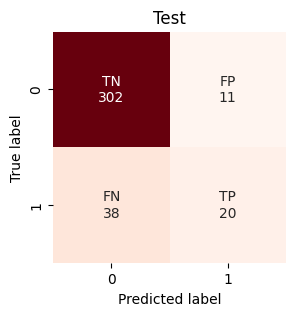

In [ ]:
result, result_sgd_default = metrics_display(sgd_default, X_test, y_test)
results.append(result)

El modelo tiene un gran rendimiento con una acurracy del 86%. Pero al momento de identificar las casos su desempeño es muy disparejo. Para la mayoria de los casos, es decir, prestamo pagado [0] tiene un precision y recall altos > 90% pero para los otros casos, prestamo no pagado [1] su resultados son < 50%. Esto indica que el modelo tiende a predecir de forma incorrecto que los clientes que incumplieron el pago si lograron pagar el préstamo

#### 2.2 SGDClassifier con ajuste de hiperparámetros

El dataset presenta un gran desbalanace entre los valores positivos y negativos de la variable objetivo. No es recomendable utilizar **Accuracy**, ya que se entrenara con un gran número de casos

Se define la métrica con la cual se van a buscar los mejores hiperparámetros

In [ ]:
metrica = 'f1'

Se instancia el modelo

In [ ]:
start = time.time()
sgd_pipe = Pipeline([('std', StandardScaler()),
                     ('sgd', SGDClassifier(random_state=0))])

params = { 'sgd__loss'          : ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'],
           'sgd__learning_rate' : ['adaptive', 'optimal', 'constant', 'invscaling'],
           'sgd__alpha'         : [0.0001, 0.001, 0.01, 0.1],
           'sgd__eta0'          : [0.0001, 0.001, 0.01, 0.1]}

gs_sgd = GridSearchCV(sgd_pipe,
                      param_grid=params,
                      scoring=metrica,
                      cv=5)

gs_sgd.fit(X_train, y_train)
end = time.time()
print(f"Tiempo: {end - start:.2f} segundos")

Tiempo: 40.51 segundos


El mejor resultado obtenido es

In [ ]:
print("Mejor resultado")
print("- Parámetros:",gs_sgd.best_params_)
print(f"- F1:\t      {gs_sgd.best_score_:.4f}")

Mejor resultado
- Parámetros: {'sgd__alpha': 0.01, 'sgd__eta0': 0.0001, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'perceptron'}
- F1:	      0.4946


Se observan las métricas del modelo con los hiperparametros encontrados

Test results:
Precision:	0.418
Recall:		0.483
F1-Score:	0.448
Accuracy:	0.814


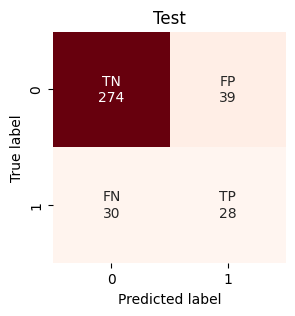

In [ ]:
result, result_sgd_hparam = metrics_display(gs_sgd, X_test, y_test)
results.append(result)

El modelo es inferior en terminos de accuracy comparado con el anterior (86% vs. 81%). Aunque tiene una leve mejora: mayor recall para los casos de prestamo no pagado [1] y mayor precision para los casos de prestamo pagado [0]. En general el modelo es un poco más balanceado que el anterior

#### 3.1 DecisionTreeClassifier con hiperparámetros por defecto

In [ ]:
dtc_default = Pipeline([('scaler', StandardScaler()),
                        ('dtc', DecisionTreeClassifier(random_state=0))])

In [ ]:
dtc_default.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('dtc', DecisionTreeClassifier(random_state=0))])

Test results:
Precision:	0.617
Recall:		0.638
F1-Score:	0.627
Accuracy:	0.881


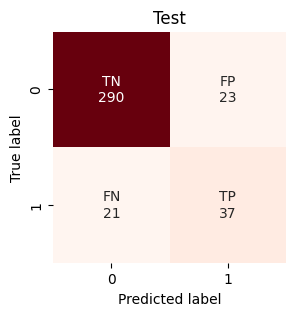

In [ ]:
result, result_dtc_default = metrics_display(dtc_default, X_test, y_test)
results.append(result)

El modelo presenta un mejor resultado general comparado con los anteriores, tiene una mejora significavimante en la identificacion de los casos prestamo no pagado [1] de un 40% a > 60%. Es más adecuado para aplicaciones donde se requiere identificar ambos resultados

#### 3.2 DecisionTreeClassifier con ajuste de hiperparámetros

In [ ]:
metrica = 'f1'

In [ ]:
start = time.time()
dtc_pipe = Pipeline([('std', StandardScaler()),
                     ('dtc', DecisionTreeClassifier(random_state=0))])

params = {  'dtc__criterion': ['gini', 'entropy', 'log_loss'],
            'dtc__splitter': ['best', 'random'],
            'dtc__max_depth': [30, 40, 50, None],
            'dtc__min_samples_split': [2, 5, 10],
            'dtc__min_samples_leaf': [1, 2, 4]}

gs_dtc = GridSearchCV(dtc_pipe,
                      param_grid=params,
                      scoring=metrica,
                      cv=5)

gs_dtc.fit(X_train, y_train)
end = time.time()
print(f"Tiempo: {end - start:.2f} segundos")

Tiempo: 18.08 segundos


In [ ]:
print("Mejor resultado")
print("- Parámetros:",gs_dtc.best_params_)
print(f"- F1:\t      {gs_dtc.best_score_:.4f}")

Mejor resultado
- Parámetros: {'dtc__criterion': 'entropy', 'dtc__max_depth': 30, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2, 'dtc__splitter': 'random'}
- F1:	      0.6084


Test results:
Precision:	0.692
Recall:		0.621
F1-Score:	0.655
Accuracy:	0.898


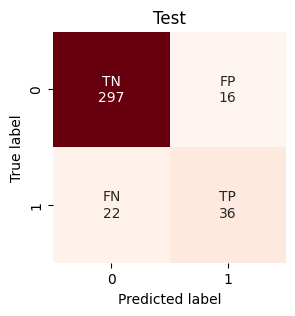

In [ ]:
result, result_dtc_hparam = metrics_display(gs_dtc, X_test, y_test)
results.append(result)

El modelo mejora incluso más los resultados ya que presenta resultados más equilibrados

#### Conclusión

A partir de los modelos creados, se pueden graficar sus métricas

In [ ]:
columns = [ 'Precision', 'Recall', 'F1-Score', 'Accuracy']
names = ['SGD Default', 'SGD Hyperparameter', 'DecisionTree Default', 'DecisionTree Hyperparameter']
df_results = pd.DataFrame([result_sgd_default, result_sgd_hparam, result_dtc_default,result_dtc_hparam], columns=columns)
df_results.insert(0, 'Model', names, True)

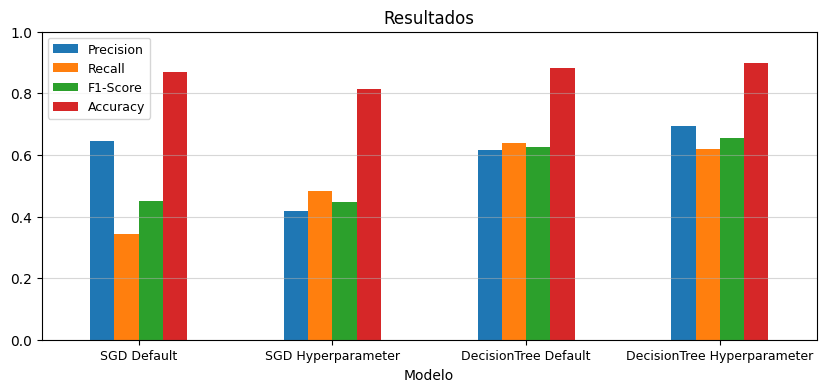

In [ ]:
df_results.set_index('Model').plot(kind = 'bar', figsize = (10, 4))

plt.title('Resultados')
plt.xlabel('Modelo')
plt.xticks(rotation = 0, fontsize = 9)
plt.ylim(0, 1)
plt.grid(axis='y', alpha = 0.5)
plt.legend(loc = 'upper left', fontsize = 9)
plt.savefig('results_precision.png', bbox_inches='tight')

Tambien se puede evaluar las curvas ROC

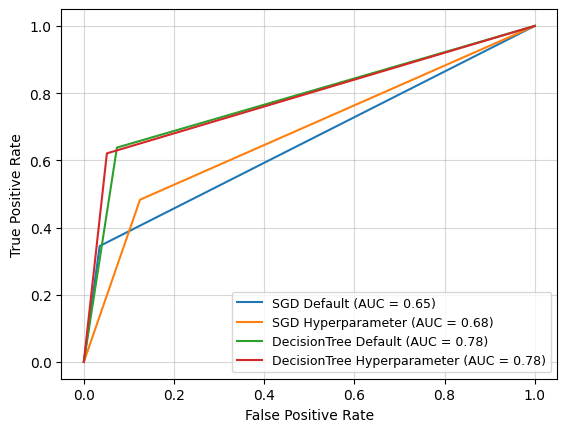

In [ ]:
fig, ax = plt.subplots()

for index in range(len(results)):
    fpr, tpr, thresholds = roc_curve(y_test, results[index])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=names[index])
    display.plot(ax=ax)

plt.legend(fontsize = 9, loc = 'lower right')
plt.grid(alpha = 0.5)
plt.show()

A partir de las curvas ROC se puede determinar:
- SGDClassifier: muestra un FPR bajo y un TPR moderado, aunque tiene una buena capacidad para identificar los negativos, su capacidad para identificar los positivos es limitada
- SGDClasffier ajustado: tiene un FPR más alto que el modelo anterior, pero un TPR un poco mejor. Esto indica que ajustar los hiperparámetros mejora la identificación de verdaderos positivos a cambio de más falsos positivos
- DecisionTreeClassifier: mejor capacidad para identificar verdaderos positivos (TPR más alto), pero también genera falsos positivos
- DecisionTreeClassifier ajustado: mejora el balance entre TPR y FPR, lo que sugiere una mejor capacidad general para discriminar entre las clases

Siendo el último el mejor modelo para estos datos, ya que es el más equilibrado y tiene un mejor balance de TPR y FPR